- Labels in this dataset:
    - 0: Helmet
    - 1: Safety_goggles
    - 2: Vest
    - 3: Hairnet
    - 4: Earplug
    - 5: No Helmet
    - 6: No safety_goggles
    - 7: No vest
    - 8: No hairnet
    - 9: No earplug
    - 10: Person

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


# Installs/Imports

In [ ]:
%%time

! pip install ultralytics==8.1.29 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.3 MB/s eta 0:00:00
CPU times: user 940 ms, sys: 220 ms, total

In [ ]:
import ultralytics
print(ultralytics.__version__)

8.1.29


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [ ]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [ ]:
folder_path = "/content/drive/MyDrive/100_Img_4500_to_4501/"

In [ ]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88


    # classes
    CLASSES = ['Helmet', 'Safety_goggles', 'Vest', 'Hairnet',
               'Earplug', 'No Helmet', 'No safety_goggles',
               'No vest', 'No hairnet', 'No earplug','Person']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 20 # 100
    BATCH_SIZE = 16

    BASE_MODEL = 'yolov8s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 5
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/content/drive/MyDrive/100_Img_4500_to_4501/'
    OUTPUT_DIR = './'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [ ]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [ ]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Helmet
- Safety_goggles
- Vest
- Hairnet
- Earplug
- No Helmet
- No safety_goggles
- No vest
- No hairnet
- "No\_earplug"
- Person
nc: 11
test: /content/drive/MyDrive/100_Img_4500_to_4501/test
train: /content/drive/MyDrive/100_Img_4500_to_4501/train
val: /content/drive/MyDrive/100_Img_4500_to_4501/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [ ]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (480, 640, 3) 



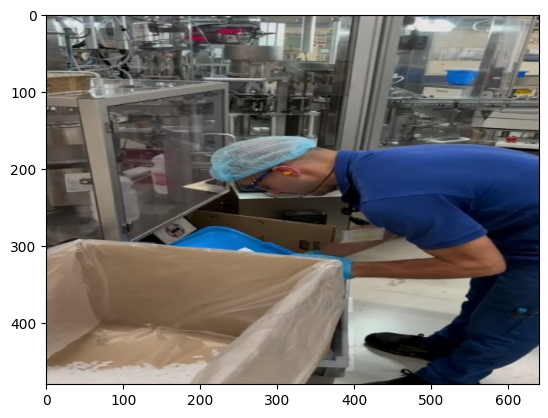

In [ ]:
example_image_path = '/content/drive/MyDrive/100_Img_4500_to_4501/train/images/IMG_4500_frame_00470.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

In [ ]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

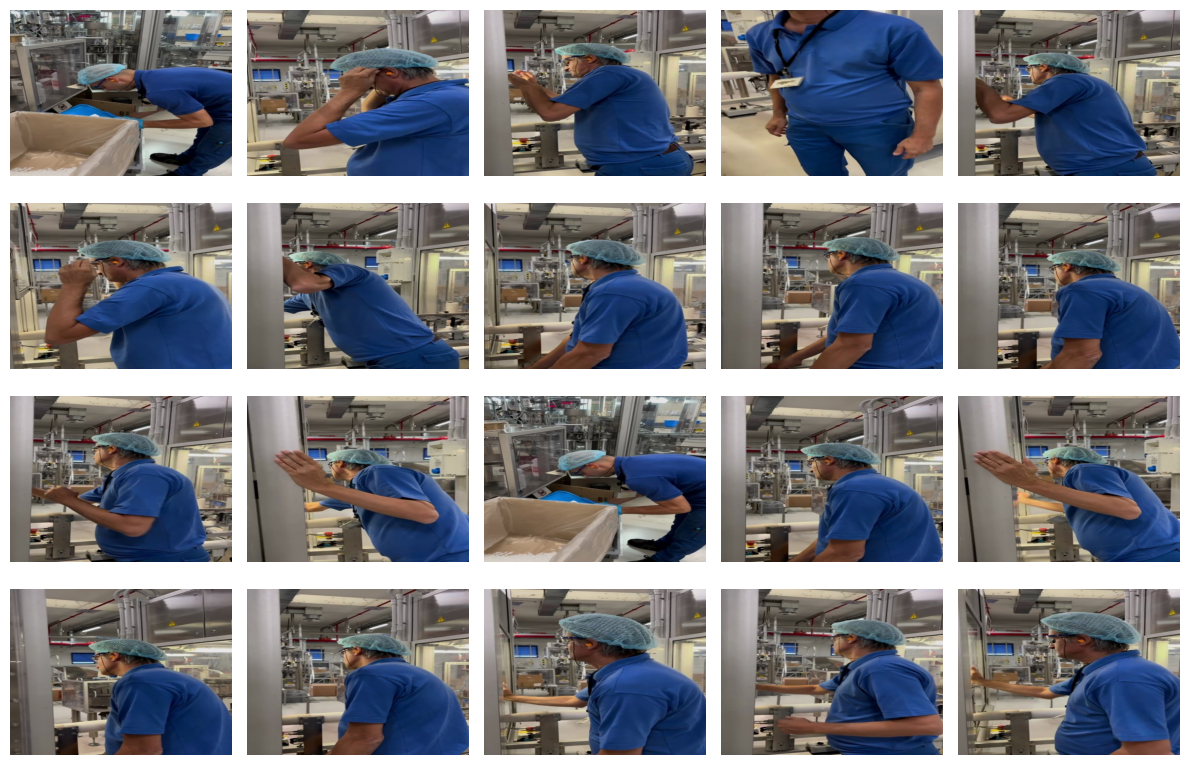

In [ ]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [ ]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [ ]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 480, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [ ]:
%%time

class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            cList1 = f.read().splitlines()

            for cls in set([line.split(' ')[0] for line in cList1]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 224 ms, sys: 60.9 ms, total: 285 ms
Wall time: 47.9 s


,Mode,Helmet,Safety_goggles,Vest,Hairnet,Earplug,No Helmet,No safety_goggles,No vest,No hairnet,No earplug,Person,Data_Volume
0,train,0,67,0,69,69,69,0,70,0,0,70,70
1,valid,0,20,0,20,20,20,0,20,0,0,20,20
2,test,0,10,0,10,10,10,0,10,0,0,10,10


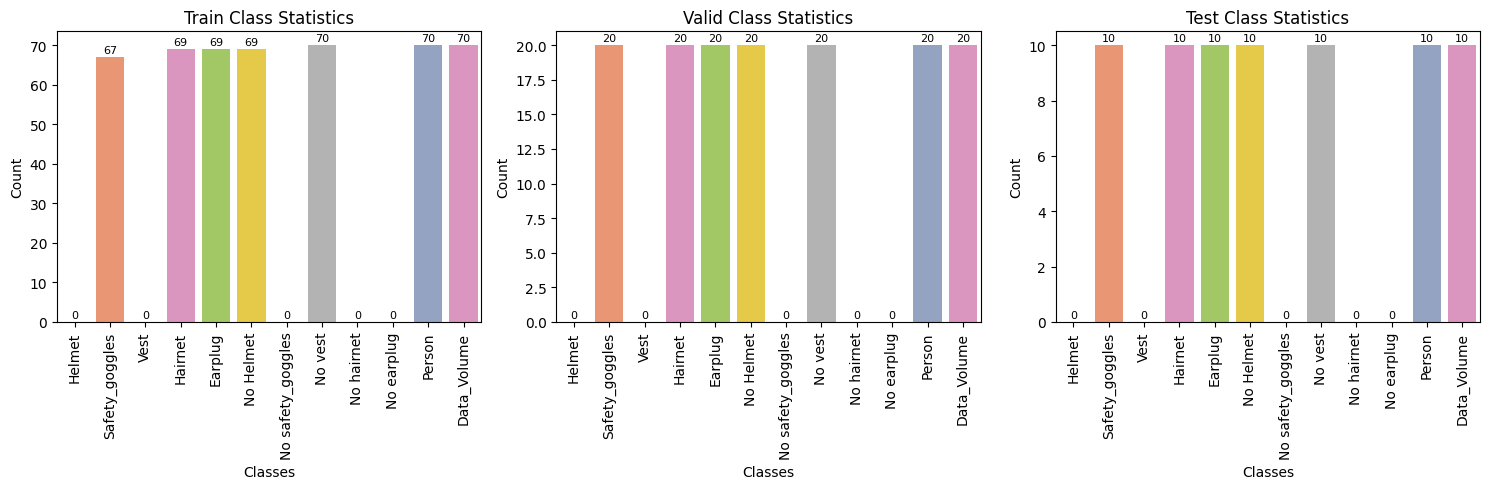

In [ ]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [ ]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 480)



Image sizes in valid set:
(640, 480)



Image sizes in test set:
(640, 480)


CPU times: user 176 ms, sys: 51.6 ms, total: 228 ms
Wall time: 31.7 s


# Base Model Inference

- Just checking the power of the pretrained model inference on the CSS dataset

In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

with tf.device('/GPU:0'):
    results = model.predict(
        source=example_image_path,
        classes=[0],
        conf=0.30,
        imgsz=(img_properties['height'], img_properties['width']),
        save=True,
        save_txt=True,
        save_conf=True,
        exist_ok=True,
    )

100%|██████████| 21.5M/21.5M [00:00<00:00, 91.4MB/s]



image 1/1 /content/drive/MyDrive/100_Img_4500_to_4501/train/images/IMG_4500_frame_00470.jpg: 480x640 1 person, 742.4ms
Speed: 9.0ms preprocess, 742.4ms inference, 42.7ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (480, 640, 3) 



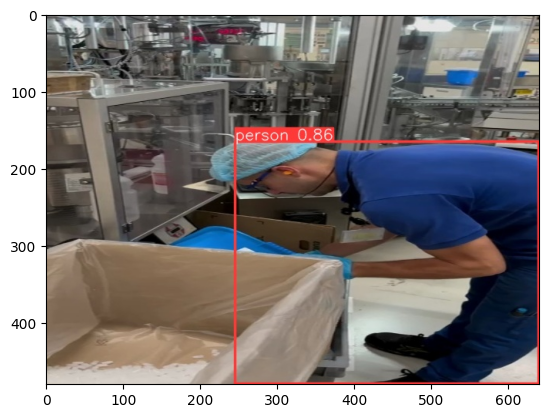

In [ ]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/content/runs/detect/predict/{example_image_inference_output}')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [ ]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8s.pt
Epochs:  20
Batch:  16


In [ ]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
%%time

### train
with tf.device('/GPU:0'):
  model.train(
      data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

      task = 'detect',

      imgsz = (img_properties['height'], img_properties['width']),

      epochs = CFG.EPOCHS,
      batch = CFG.BATCH_SIZE,
      optimizer = CFG.OPTIMIZER,
      lr0 = CFG.LR,
      lrf = CFG.LR_FACTOR,
      weight_decay = CFG.WEIGHT_DECAY,
      dropout = CFG.DROPOUT,
      fraction = CFG.FRACTION,
      patience = CFG.PATIENCE,
      profile = CFG.PROFILE,
      label_smoothing = CFG.LABEL_SMOOTHING,

      name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
      seed = CFG.SEED,

      val = True,
      amp = True,
      exist_ok = True,
      resume = False,
      verbose = False,
  )

New https://pypi.org/project/ultralytics/8.3.80 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./data.yaml, epochs=20, time=None, patience=5, batch=16, imgsz=(480, 640), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_ppe_css_20_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

100%|██████████| 755k/755k [00:00<00:00, 40.7MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

train: Scanning /content/drive/.shortcut-targets-by-id/11hSdA5dJ13vpg43Y_PH5FBF8wf5JRAjJ/100_Img_4500_to_4501/train/labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 90.01it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/11hSdA5dJ13vpg43Y_PH5FBF8wf5JRAjJ/100_Img_4500_to_4501/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/.shortcut-targets-by-id/11hSdA5dJ13vpg43Y_PH5FBF8wf5JRAjJ/100_Img_4500_to_4501/valid/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 107.65it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/11hSdA5dJ13vpg43Y_PH5FBF8wf5JRAjJ/100_Img_4500_to_4501/valid/labels.cache
Plotting labels to runs/detect/yolov8s_ppe_css_20_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8s_ppe_css_20_epochs
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.518      4.038      1.667         60        640: 100%|██████████| 5/5 [03:23<00:00, 40.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.64s/it]

                   all         20        120      0.429      0.183      0.199      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.377      2.343      1.531         81        640: 100%|██████████| 5/5 [02:57<00:00, 35.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.96s/it]

                   all         20        120      0.767      0.354      0.427      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.071      1.483      1.312         71        640: 100%|██████████| 5/5 [02:55<00:00, 35.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.90s/it]

                   all         20        120      0.679      0.575      0.575      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G     0.9982      1.232      1.267         48        640: 100%|██████████| 5/5 [02:50<00:00, 34.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.51s/it]

                   all         20        120      0.569      0.636      0.616      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G     0.9714      1.106      1.232         55        640: 100%|██████████| 5/5 [02:56<00:00, 35.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.30s/it]

                   all         20        120      0.758      0.592      0.644      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G     0.8997     0.9582      1.179         69        640: 100%|██████████| 5/5 [02:53<00:00, 34.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:13<00:00, 13.21s/it]

                   all         20        120      0.651      0.576      0.656      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G     0.9014     0.8843      1.189         75        640: 100%|██████████| 5/5 [02:49<00:00, 33.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.87s/it]

                   all         20        120       0.63      0.718      0.693       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      0.884     0.8311      1.174         54        640: 100%|██████████| 5/5 [02:51<00:00, 34.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.22s/it]

                   all         20        120      0.756      0.755      0.756      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.8947      0.847       1.18         60        640: 100%|██████████| 5/5 [02:51<00:00, 34.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.89s/it]

                   all         20        120      0.676      0.762      0.746      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.8908     0.7946      1.193         73        640: 100%|██████████| 5/5 [02:50<00:00, 34.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.73s/it]

                   all         20        120      0.692      0.721       0.73      0.447


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.8139      0.861      1.096         34        640: 100%|██████████| 5/5 [02:52<00:00, 34.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.89s/it]

                   all         20        120      0.716      0.722      0.703      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.8396     0.8459      1.135         36        640: 100%|██████████| 5/5 [02:49<00:00, 33.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.67s/it]

                   all         20        120      0.767      0.705      0.724      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      0.826     0.8032      1.071         36        640: 100%|██████████| 5/5 [02:50<00:00, 34.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.66s/it]

                   all         20        120      0.713       0.74      0.742      0.432
Stopping training early as no improvement observed in last 5 epochs. Best results observed at epoch 8, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.688 hours.
Optimizer stripped from runs/detect/yolov8s_ppe_css_20_epochs/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_ppe_css_20_epochs/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_ppe_css_20_epochs/weights/best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11129841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:12<00:00, 12.26s/it]


                   all         20        120      0.756      0.755      0.756      0.477
Speed: 2.0ms preprocess, 574.1ms inference, 0.0ms loss, 15.8ms postprocess per image
Results saved to runs/detect/yolov8s_ppe_css_20_epochs
CPU times: user 39min 9s, sys: 2min 7s, total: 41min 17s
Wall time: 41min 52s


# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv8 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [ ]:
img_properties

{'width': 640, 'height': 480, 'channels': 3, 'dtype': dtype('uint8')}

In [ ]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.29 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11129841 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'runs/detect/yolov8s_ppe_css_20_epochs/weights/best.pt' with input shape (1, 3, 480, 640) BCHW and output shape(s) (1, 15, 6300) (21.5 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 63.9 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 15.4s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 17.6s, saved as 'runs/detect/yolov8s_ppe_css_20_epochs/weights/best.onnx' (42.6 MB)

Export complete (20.2s)
Results saved to /content/runs/detect/yolov8s_ppe_css_20_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov8s_ppe_css_20_epochs/w

'runs/detect/yolov8s_ppe_css_20_epochs/weights/best.onnx'

# Train results

In [ ]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8s_ppe_css_20_epochs/PR_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/F1_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/P_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/results.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/R_curve.png',
 './runs/detect/yolov8s_ppe_css_20_epochs/labels_correlogram.jpg',
 './runs/detect/yolov8s_ppe_css_20_epochs/labels.jpg']

./runs/detect/yolov8s_ppe_css_20_epochs/F1_curve.png


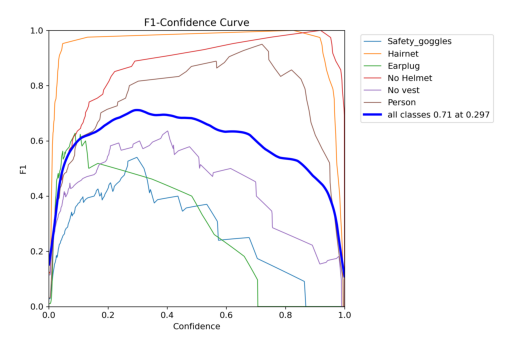



./runs/detect/yolov8s_ppe_css_20_epochs/PR_curve.png


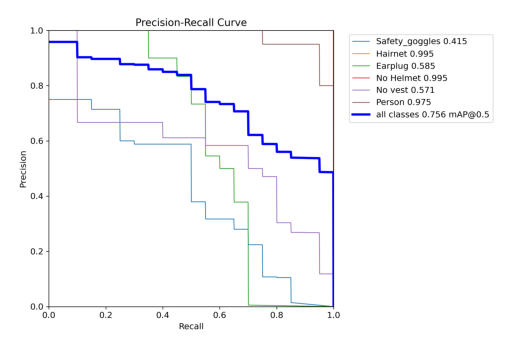



./runs/detect/yolov8s_ppe_css_20_epochs/P_curve.png


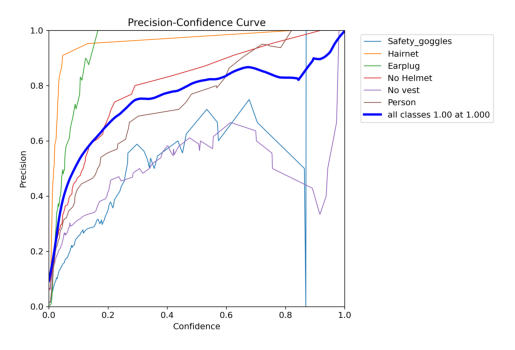



./runs/detect/yolov8s_ppe_css_20_epochs/R_curve.png


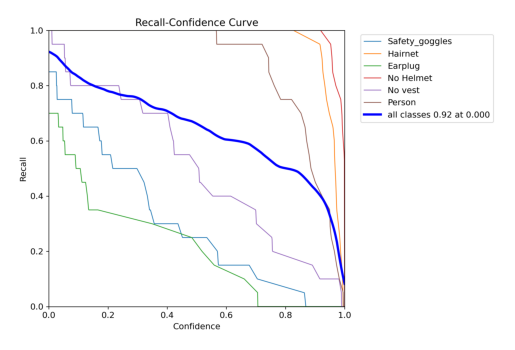



./runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix.png


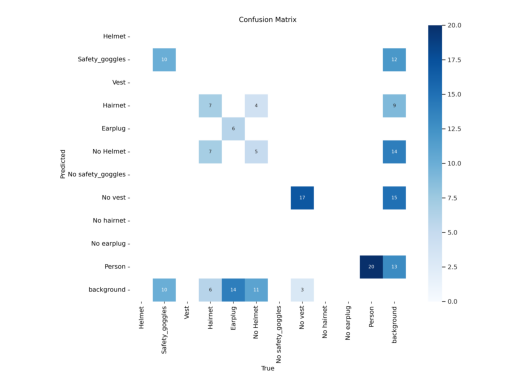



./runs/detect/yolov8s_ppe_css_20_epochs/confusion_matrix_normalized.png


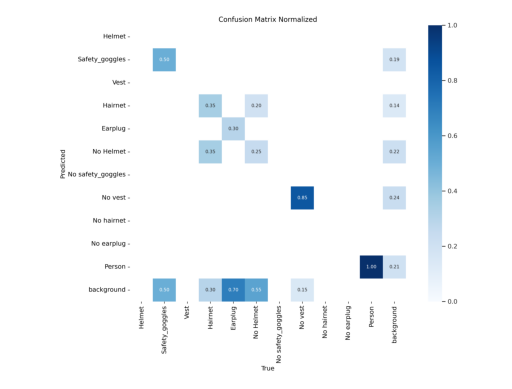



./runs/detect/yolov8s_ppe_css_20_epochs/labels.jpg


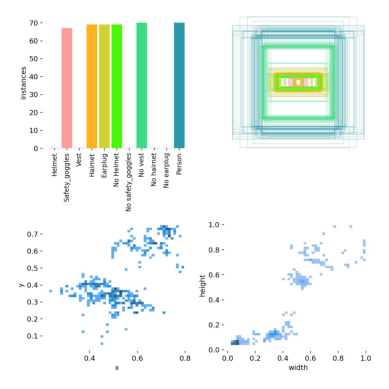



./runs/detect/yolov8s_ppe_css_20_epochs/labels_correlogram.jpg


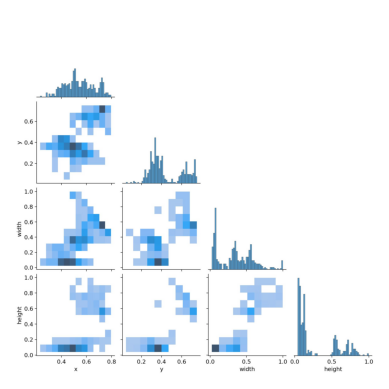



./runs/detect/yolov8s_ppe_css_20_epochs/results.png


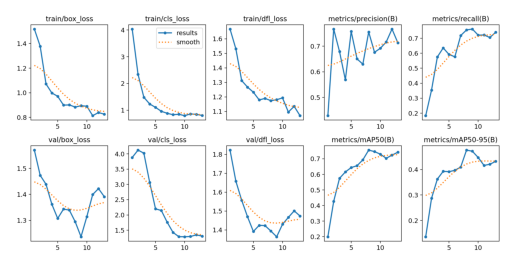

In [ ]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.51750,4.03820,1.6671,0.42863,0.18333,0.19934,0.13584,1.5702,3.8803,1.8226,0.000027,0.000027,0.000027
1,2,1.37740,2.34300,1.5306,0.76713,0.35434,0.42705,0.28711,1.4731,4.1221,1.6580,0.000057,0.000057,0.000057
2,3,1.07140,1.48290,1.3120,0.67891,0.57530,0.57484,0.36279,1.4388,4.0218,1.5567,0.000084,0.000084,0.000084
3,4,0.99818,1.23250,1.2671,0.56866,0.63552,0.61561,0.39315,1.3619,3.0649,1.4695,0.000108,0.000108,0.000108
4,5,0.97135,1.10560,1.2321,0.75772,0.59167,0.64374,0.39177,1.3075,2.2006,1.3919,0.000128,0.000128,0.000128
5,6,0.89971,0.95818,1.1791,0.65051,0.57636,0.65562,0.39711,1.3434,2.1456,1.4243,0.000146,0.000146,0.000146
6,7,0.90137,0.88433,1.1894,0.62994,0.71812,0.69333,0.40994,1.3395,1.7610,1.4228,0.000159,0.000159,0.000159
7,8,0.88402,0.83106,1.1740,0.75565,0.75542,0.75586,0.47661,1.2949,1.4287,1.3940,0.000170,0.000170,0.000170
8,9,0.89474,0.84702,1.1804,0.67631,0.76159,0.74615,0.47217,1.2370,1.2893,1.3637,0.000177,0.000177,0.000177
9,10,0.89084,0.79459,1.1931,0.69202,0.72067,0.72983,0.44746,1.3145,1.2866,1.4300,0.000181,0.000181,0.000181


In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.81394 , on epoch:  11 


Best Validation Box loss:  1.237 , on epoch:  9 


Best Training Cls loss:  0.79459 , on epoch:  10 


Best Validation Cls loss:  1.2866 , on epoch:  10 


Best Training DFL loss:  1.0705 , on epoch:  13 


Best Validation DFL loss:  1.3637 , on epoch:  9 



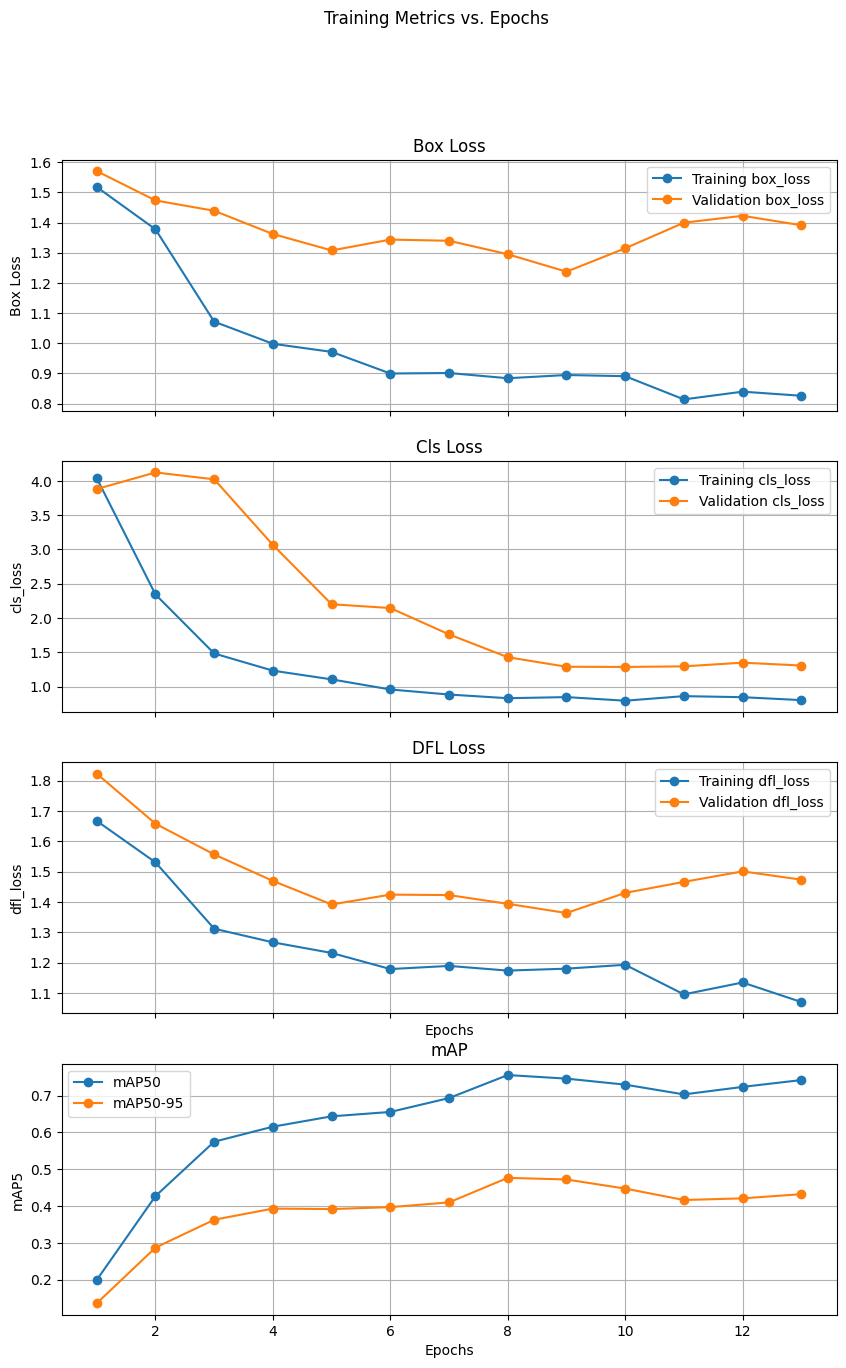

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

### Training and Validation dfl_loss
ax4.set_title('mAP')
ax4.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', marker='o', linestyle='-')
ax4.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', marker='o', linestyle='-')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('mAP5')
ax4.legend()
ax4.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

# Validation results

In [ ]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

2

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8s_ppe_css_20_epochs/val_batch0_pred.jpg


./runs/detect/yolov8s_ppe_css_20_epochs/val_batch0_labels.jpg


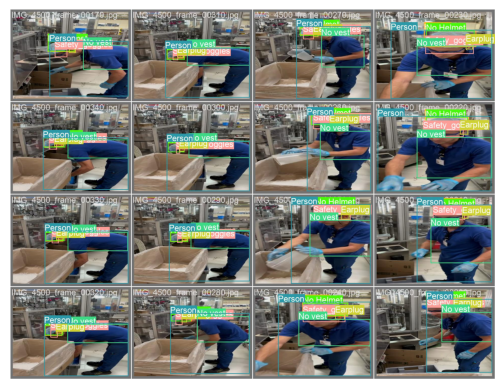

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)